<a href="https://colab.research.google.com/github/cTxplorer/deep-learning-v2-pytorch/blob/master/Final_Lab_DenseNet161.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. Install & Imports

In [0]:
# Install torch 0.4 
# google colab does not come with torch installed.

from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision
import torch

In [0]:
# To install pillow 5.3.0,
#   first uninstall the older version

!pip uninstall -y Pillow
!pip install Pillow==5.3.0

import PIL
print('installed ', PIL.PILLOW_VERSION)

# this should print 5.3.0
# If it doesn't, then restart your runtime:
#   Menu > Runtime > Restart Runtime

Uninstalling Pillow-5.3.0:
  Successfully uninstalled Pillow-5.3.0
  Using cached https://files.pythonhosted.org/packages/62/94/5430ebaa83f91cc7a9f687ff5238e26164a779cca2ef9903232268b0a318/Pillow-5.3.0-cp36-cp36m-manylinux1_x86_64.whl
installed  5.3.0


In [0]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import time
import json
import copy

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from PIL import Image
from collections import OrderedDict

import torch
import torchvision
from torch import nn
from torch import optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
from torchvision import datasets, models, transforms

In [0]:
# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


## 2. Load, Prepare & Visualize Data

In [0]:
# download the flower dataset
!wget -cq https://s3.amazonaws.com/content.udacity-data.com/courses/nd188/flower_data.zip
!wget -cq https://github.com/udacity/pytorch_challenge/raw/master/cat_to_name.json
!rm -r flower_data || true
!unzip -qq flower_data.zip
!ls flower_data

train  valid


In [0]:
# map data with respective directories
train_dir = 'flower_data/train'
valid_dir = 'flower_data/valid'

dirs = {'train': train_dir, 
        'valid': valid_dir}

### Define *tranforms*, load *datasets* & then define *dataloaders*

In [0]:
# define batch size
batch_size = 32

In [0]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomRotation(45),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], 
                             [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], 
                             [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], 
                             [0.229, 0.224, 0.225])
    ]),
}

image_datasets = {
    x: datasets.ImageFolder(dirs[x], transform=data_transforms[x])
    for x in ['train', 'valid']
}

dataloaders = {
    x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True)
    for x in ['train', 'valid']
}

dataset_sizes = {
    x: len(image_datasets[x])
    for x in ['train', 'valid']
}

class_names = image_datasets['train'].classes

### Map flower names with catergorical numerals

In [0]:
with open('cat_to_name.json', 'r') as f:
    label_map = json.load(f)

### Visualize some images

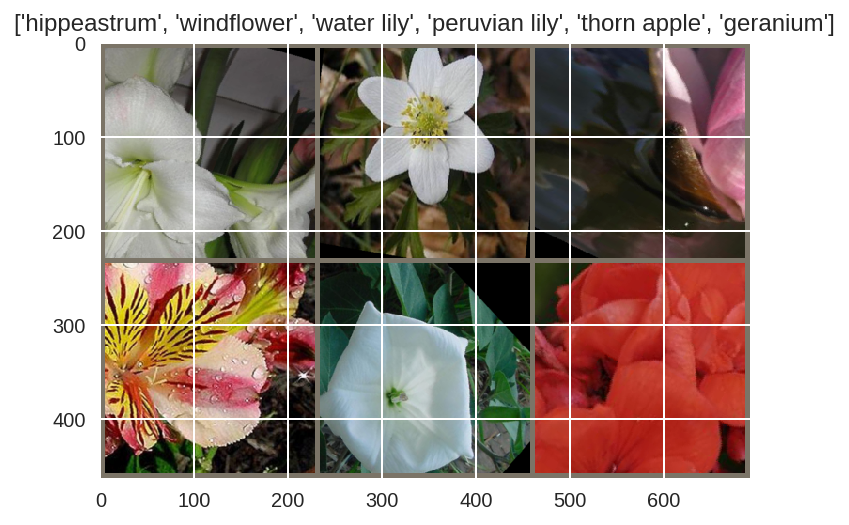

In [0]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

# Get a batch of training data
print_n = 6
inputs, classes = next(iter(dataloaders['train']))
inputs, classes = inputs[:print_n], classes[:print_n]

# Make a grid from batch
out = torchvision.utils.make_grid(inputs, nrow = 3, padding = 5)

imshow(out, title=[label_map[class_names[x]] for x in classes])

# 3. Define model

### Use pretrained model

In [0]:
model = models.densenet161(pretrained=True)
model.classifier

/usr/local/lib/python3.6/dist-packages/torchvision/models/densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data)
Downloading: "https://download.pytorch.org/models/densenet161-8d451a50.pth" to /root/.torch/models/densenet161-8d451a50.pth
100%|██████████| 115730790/115730790 [00:01<00:00, 61868296.36it/s]


Linear(in_features=2208, out_features=1000, bias=True)

### Create our classifier
`in_features` in first NN layer is 25088

`out_features` in last NN layer is 102

In [0]:
classifier = nn.Sequential(
      nn.Linear(2208, 512),
      nn.ReLU(512),
      nn.Dropout(p=0.5),
      nn.Linear(512, 512),
      nn.ReLU(512),
      nn.Dropout(p=0.5),
      nn.Linear(512, 102),
      nn.LogSoftmax(dim=1))
classifier

Sequential(
  (0): Linear(in_features=2208, out_features=512, bias=True)
  (1): ReLU(inplace)
  (2): Dropout(p=0.5)
  (3): Linear(in_features=512, out_features=512, bias=True)
  (4): ReLU(inplace)
  (5): Dropout(p=0.5)
  (6): Linear(in_features=512, out_features=102, bias=True)
  (7): LogSoftmax()
)

In [0]:
# Ensure that we don't update weights in pretrained model
for param in model.parameters():
    param.requires_grad = False

In [0]:
# Replace classifier of the pretrained model with our classifier
model.classifier = classifier

# 4. Train the model

In [0]:
def train_model(model, criteria, optimizer, scheduler, num_epochs=15, device='cuda'):
    since = time.time()
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'valid']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criteria(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [0]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
# Criteria NLLLoss which is recommended with Softmax final layer
criteria = nn.NLLLoss()
# Observe that all parameters are being optimized
optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)
# Decay LR by a factor of 0.1 every 4 epochs
sched = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
# Number of epochs
eps=35

In [0]:
model_ft = train_model(model, criteria, optimizer, sched, eps, device)

Epoch 1/35
----------
train Loss: 4.1301 Acc: 0.1018
valid Loss: 2.7690 Acc: 0.3753

Epoch 2/35
----------
train Loss: 2.7664 Acc: 0.2972
valid Loss: 1.5641 Acc: 0.5746

Epoch 3/35
----------
train Loss: 2.1814 Acc: 0.4180
valid Loss: 1.1274 Acc: 0.7188

Epoch 4/35
----------
train Loss: 1.8896 Acc: 0.4889
valid Loss: 0.9054 Acc: 0.7555

Epoch 5/35
----------
train Loss: 1.7310 Acc: 0.5212
valid Loss: 0.7600 Acc: 0.7983

Epoch 6/35
----------
train Loss: 1.6077 Acc: 0.5586
valid Loss: 0.6785 Acc: 0.8215

Epoch 7/35
----------
train Loss: 1.4849 Acc: 0.5850
valid Loss: 0.5753 Acc: 0.8619

Epoch 8/35
----------
train Loss: 1.4860 Acc: 0.5846
valid Loss: 0.5627 Acc: 0.8460

Epoch 9/35
----------
train Loss: 1.4258 Acc: 0.6058
valid Loss: 0.5313 Acc: 0.8557

Epoch 10/35
----------
train Loss: 1.4225 Acc: 0.6113
valid Loss: 0.5173 Acc: 0.8716

Epoch 11/35
----------
train Loss: 1.2066 Acc: 0.6589
valid Loss: 0.4193 Acc: 0.8949

Epoch 12/35
----------
train Loss: 1.1512 Acc: 0.6799
valid Los

In [0]:
model_ft

# 5. Saving the model

In [0]:
model.class_to_idx = image_datasets['train'].class_to_idx
model.cpu()
torch.save({'arch': 'densenet161',
            'state_dict': model.state_dict(), 
            'class_to_idx': model.class_to_idx}, 
            'densenet161.pth') 

### Save to Drive for future use

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
model_save_name = 'densenet161.pth'
path = F"/content/gdrive/My Drive/Deep Learning/{model_save_name}" 
torch.save(model.state_dict(), path)

In [0]:
!ls '/content/gdrive/My Drive/Deep Learning'

 densenet161.pth  '#side project plan.gdoc'   vgg19_low_acc.pt
 densenet201.pth   vgg19_02.pt
